<a href="https://colab.research.google.com/github/87tana/Brain_Tumor_Classification_Network_Comparison/blob/main/Brain_Tumor_Classification_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [2]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data preprocessing
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# For ML Models
from tensorflow.keras.applications import Xception, ResNet50, MobileNet, VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Miscellaneous
from tqdm import tqdm
import os
import random

## 2. Reading the Data

In [3]:
def read_dataset(data_path):
    data = []

    for label in os.listdir(data_path):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']:
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(os.path.join(data_path,label)):
            data.append([os.path.join(data_path,label,image),real_label])

    return data

### 2.1. Setting the Base Directory and Subdirectories:

In [4]:
image_data_paths = r"drive/MyDrive/Tumor_Classification/brain_tumor_dataset_train_test"
train_dir = os.path.join(image_data_paths,"Training")
test_dir = os.path.join(image_data_paths,"Testing")

train_data = shuffle(read_dataset(train_dir))
print(f'training image number: {len(train_data)}')

test_data = read_dataset(test_dir)
print(f'test image number: {len(test_data)}')

training image number: 2900
test image number: 394


In [5]:
train_data = pd.DataFrame(train_data, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
train_data.head(2)

,image_filepaths,tumor_class
0,drive/MyDrive/Tumor_Classification/brain_tumor...,glioma
1,drive/MyDrive/Tumor_Classification/brain_tumor...,glioma


In [6]:
test_data = pd.DataFrame(test_data, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
test_data.head(2)

,image_filepaths,tumor_class
0,drive/MyDrive/Tumor_Classification/brain_tumor...,glioma
1,drive/MyDrive/Tumor_Classification/brain_tumor...,pituitary


## 3. Data Visualization Distribution for each class

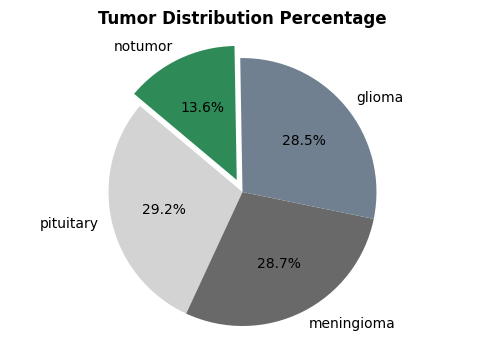

In [7]:
label_counts = train_data['tumor_class'].value_counts().to_dict()  # Count occurrences of each label
total_count = sum(label_counts.values())
label_percentages = {label: count / total_count * 100 for label, count in label_counts.items()}

# Create a pie chart
plt.figure(figsize=(6, 4))
colors = ['lightgray','dimgray', 'slategrey','seagreen']
explode = (0, 0,0,0.1) #Explode the 1st slice (optional, for emphasis)
plt.pie(label_percentages.values(), labels=label_percentages.keys(), autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Tumor Distribution Percentage',weight='bold')
plt.show()

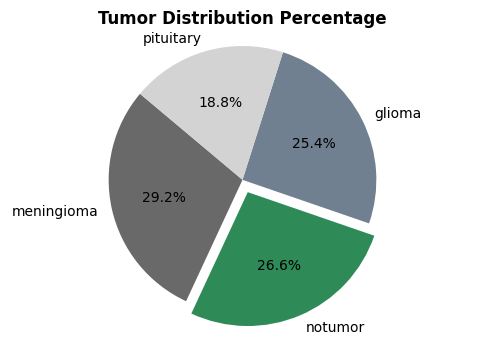

In [8]:
label_counts = test_data['tumor_class'].value_counts().to_dict()  # Count occurrences of each label
total_count = sum(label_counts.values())
label_percentages = {label: count / total_count * 100 for label, count in label_counts.items()}

# Create a pie chart
plt.figure(figsize=(6, 4))
colors = ['dimgray','seagreen', 'slategrey', 'lightgray']
explode = (0, 0.1,0,0) #Explode the 1st slice
plt.pie(label_percentages.values(), labels=label_percentages.keys(), autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Tumor Distribution Percentage',weight='bold')
plt.show()

## 4. Splitting Training Data into Training and Validation Sets:

In [9]:
train_data, val_data = train_test_split(train_data,
                                               train_size = 0.85,
                                               random_state = 42,
                                               stratify = train_data.tumor_class)

In [10]:
print(train_data.shape),
print(val_data.shape),
print(test_data.shape)

(2465, 2)
(435, 2)
(394, 2)


## 5. Data Augmentation and Normalization(Rescaling)

- Image augmentation is a technique employed in ML for two primary purposes: to **expand the image dataset** and **enhance the neural network's resilience to translation invariance**.



- This involves generating additional images by applying operations such as flipping, rotating, zooming, and adjusting brightness to the original dataset.

- Apply rescaling to all three datasets (train, validation, and test) for comparability. However, limit data augmentation techniques to the training dataset only, excluding the test and validation sets. This ensures that the model is evaluated on its ability to make predictions on unseen, unaltered data during the testing and validation phases.

In [11]:
image_size = 128
batch_size = 64

train_image_datagen_kwargs = dict(rescale = 1 / 255,
                                rotation_range = 15,
                                width_shift_range = 0.1,
                                zoom_range = 0.02,
                                shear_range = 0.01,
                                brightness_range = [0.3, 1.5],
                                horizontal_flip = True,
                                vertical_flip = True,
                                fill_mode = "nearest"
                                )

test_image_datagen_kwargs = dict(rescale = 1 / 255)

## 6. Data Generator

In [12]:
train_image_datagen = ImageDataGenerator(**train_image_datagen_kwargs) #generating batches of training data with augmentation.
val_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs) #generating batches of validation data without augmentation.
test_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs)#generating batches of test data without augmentation.

- flow_from_dataframe allows you to apply these augmentations on-the-fly during training.

In [13]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')

val_dataset = val_image_datagen.flow_from_dataframe(val_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        shuffle=False,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')


test_dataset = test_image_datagen.flow_from_dataframe(test_data,
                                                      x_col = 'image_filepaths',
                                                      y_col = 'tumor_class',
                                                      seed = 42,
                                                      shuffle=False,
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 2465 validated image filenames belonging to 4 classes.
Found 435 validated image filenames belonging to 4 classes.
Found 394 validated image filenames belonging to 4 classes.


## 7. Model Development

In [14]:
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 10)

- The "monitor" is like a metric that the callback keeps an eye on to see if things are getting better. In this situation, it's looking at 'val_accuracy,' which means it's checking how well the model is doing on the validation data.


- The "patience" is the number of epochs with no improvement after which training will be stopped. here, if the validation accuracy does not improve for 10 consecutive epochs, the training will be stopped.

- The EarlyStopping callback in Keras is used to stop training the neural network model when a monitored metric has stopped improving.

In [15]:
def model_def(base_model):

  # Set all layers to non-trainable
  for layer in base_model.layers:
      layer.trainable = False
  # Set the last block to trainable
  base_model.layers[-2].trainable = True   #unfreeze the last 3 layers
  base_model.layers[-3].trainable = True
  base_model.layers[-4].trainable = True

  # build a custom model
  model = Sequential()
  model.add(Input(shape=(image_size,image_size,3)))
  model.add(base_model) #Adds the pre-trained base model to the model.
  model.add(Flatten())  #Flattens the output
  model.add(Dropout(0.3)) # Applies dropout with a rate of 0.3 to reduce overfitting.
  model.add(Dense(128, activation='relu')) # Adds a fully connected layer with 128 units
  model.add(Dropout(0.2)) # Applies another dropout with a rate of 0.2.
  model.add(Dense(4, activation='softmax'))

  return model

### 7.1 Development of VGG16

In [16]:
model_vgg = model_def(VGG16(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

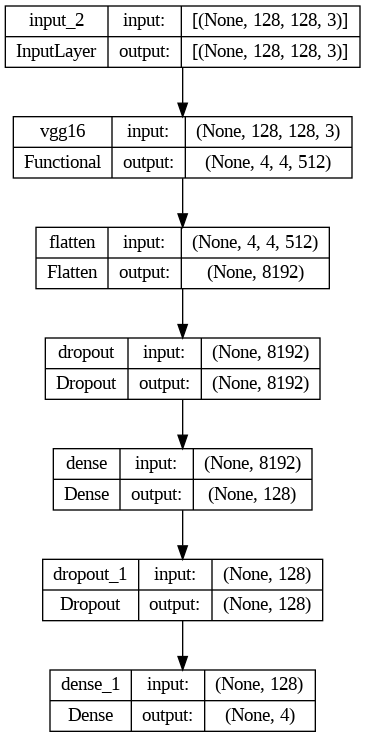

In [17]:
keras.utils.plot_model(model_vgg, show_shapes=True)

In [18]:
model_vgg.compile(optimizer=Adam(learning_rate=0.0005),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [19]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg/epocch_{epoch:02d}.hdf5"

model_vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [20]:
%%time
train_history_vgg = model_vgg.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 30,
                          callbacks = [early_stopping, model_vgg_checkpoint_callback])

Epoch 1/30
39/39 [==============================] - 726s 18s/step - loss: 1.3543 - categorical_accuracy: 0.3473 - val_loss: 1.1557 - val_categorical_accuracy: 0.4483
Epoch 2/30
39/39 [==============================] - 21s 531ms/step - loss: 1.1072 - categorical_accuracy: 0.5091 - val_loss: 1.0324 - val_categorical_accuracy: 0.5885
Epoch 3/30
39/39 [==============================] - 22s 565ms/step - loss: 0.9010 - categorical_accuracy: 0.6170 - val_loss: 0.7633 - val_categorical_accuracy: 0.7310
Epoch 4/30
39/39 [==============================] - 21s 529ms/step - loss: 0.7885 - categorical_accuracy: 0.7026 - val_loss: 0.6782 - val_categorical_accuracy: 0.7241
Epoch 5/30
38/39 [============================>.] - ETA: 0s - loss: 0.5872 - categorical_accuracy: 0.7755
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg/epocch_05.hdf5
39/39 [==============================] - 22s 574ms/step - loss: 0.5834 - categorical_accuracy: 0.7769 - val_loss: 0.4717 - val_cat

In [21]:
print(train_history_vgg.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


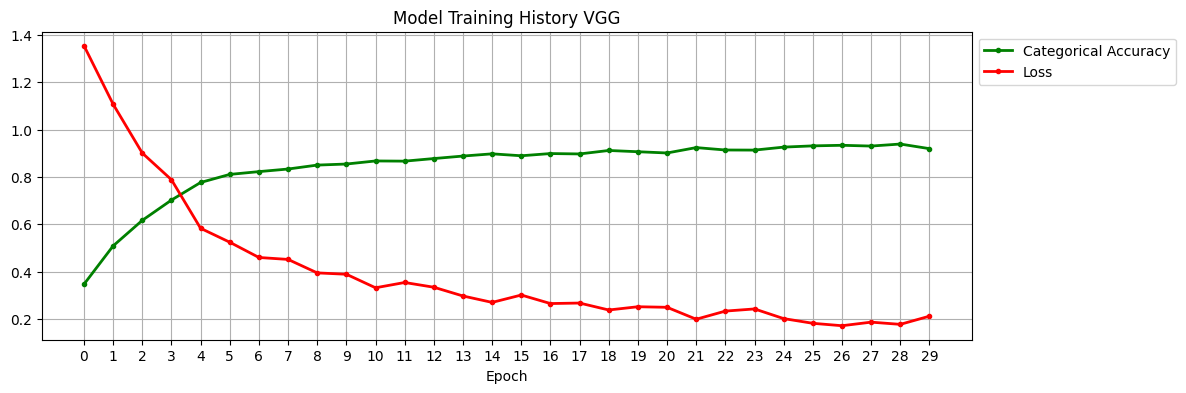

In [22]:
plt.figure(figsize=(12, 4))
plt.grid(True)
plt.plot(train_history_vgg.history['categorical_accuracy'], '.g-', linewidth=2, label='Categorical Accuracy')
plt.plot(train_history_vgg.history['loss'], '.r-', linewidth=2, label='Loss')
plt.title('Model Training History VGG')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history_vgg.history['categorical_accuracy'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

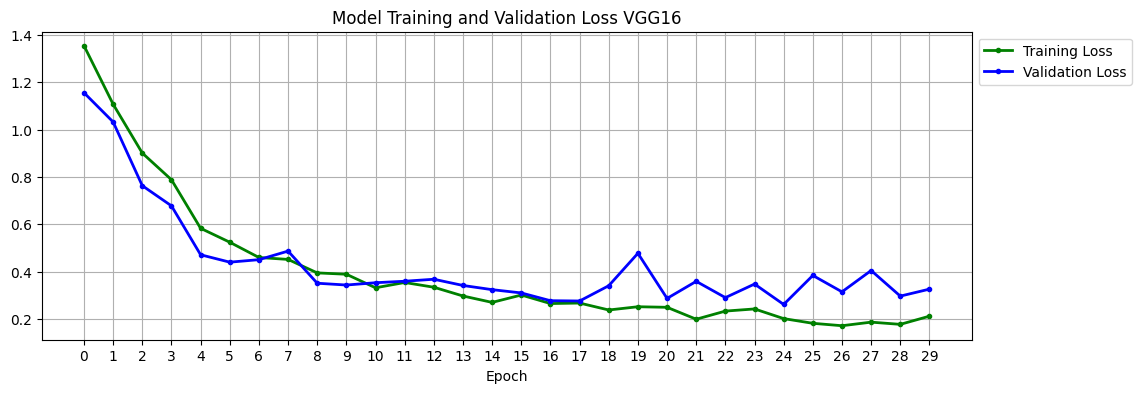

In [23]:
plt.figure(figsize=(12, 4))
plt.grid(True)

# Plot training loss
plt.plot(train_history_vgg.history['loss'], '.g-', label='Training Loss', linewidth=2)

# Plot validation loss if available
if 'val_loss' in train_history_vgg.history:
    plt.plot(train_history_vgg.history['val_loss'], '.b-', label='Validation Loss', linewidth=2)

plt.title('Model Training and Validation Loss VGG16')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history_vgg.history['loss'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [24]:
# Evaluate the model on the test set for VGG16
evaluation_results_vgg = model_vgg.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_vgg[0]}')
print(f'Test Accuracy: {evaluation_results_vgg[1]}')

7/7 [==============================] - 78s 13s/step - loss: 2.6712 - categorical_accuracy: 0.7259
Test Loss: 2.671205520629883
Test Accuracy: 0.7258883118629456


In [25]:
y_perd_vgg = model_vgg.predict(test_dataset)

7/7 [==============================] - 1s 182ms/step


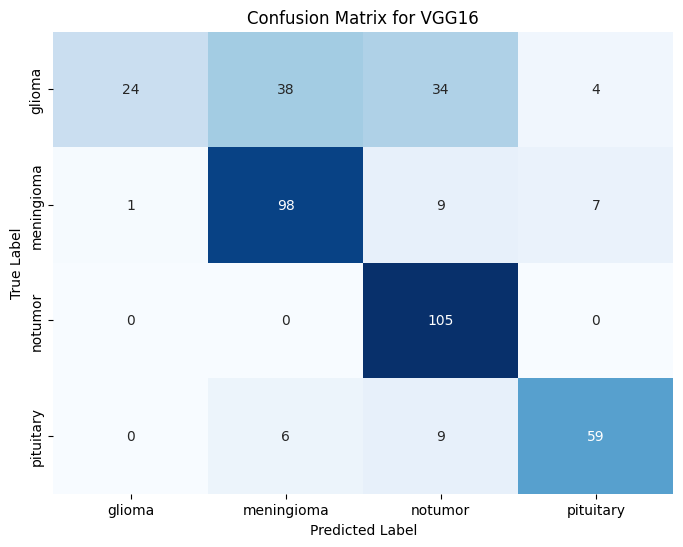

In [26]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix for VGG16
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_vgg,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for VGG16')
plt.show()

In [27]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_vgg,axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.24      0.38       100
           1       0.69      0.85      0.76       115
           2       0.67      1.00      0.80       105
           3       0.84      0.80      0.82        74

    accuracy                           0.73       394
   macro avg       0.79      0.72      0.69       394
weighted avg       0.78      0.73      0.69       394



### 7.2 Development of Xception model

In [28]:
model_xception =  model_def(Xception(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_xception.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                       

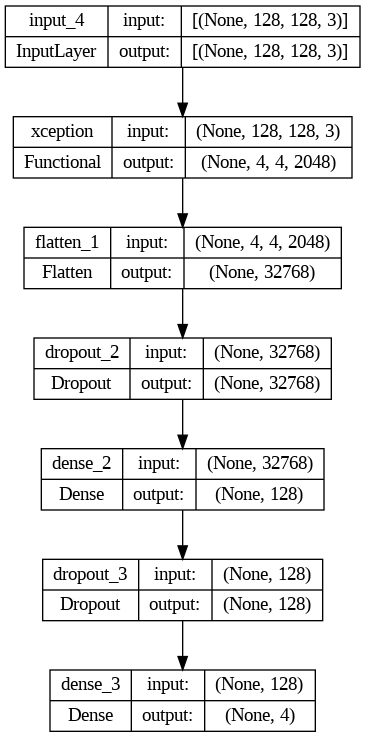

In [29]:
keras.utils.plot_model(model_xception, show_shapes=True)

In [30]:
model_xception.compile(optimizer=Adam(learning_rate = 0.0001),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [31]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/xception/epocch_{epoch:02d}.hdf5"

model_xception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [32]:
%%time
train_history_xception = model_xception.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 30,
                          callbacks = [early_stopping, model_xception_checkpoint_callback])

Epoch 1/30
39/39 [==============================] - 30s 603ms/step - loss: 0.8812 - categorical_accuracy: 0.6495 - val_loss: 0.6102 - val_categorical_accuracy: 0.7609
Epoch 2/30
39/39 [==============================] - 23s 582ms/step - loss: 0.5786 - categorical_accuracy: 0.7793 - val_loss: 0.5233 - val_categorical_accuracy: 0.7885
Epoch 3/30
39/39 [==============================] - 21s 544ms/step - loss: 0.5307 - categorical_accuracy: 0.8000 - val_loss: 0.4703 - val_categorical_accuracy: 0.8207
Epoch 4/30
39/39 [==============================] - 22s 573ms/step - loss: 0.4664 - categorical_accuracy: 0.8260 - val_loss: 0.4438 - val_categorical_accuracy: 0.8299
Epoch 5/30
38/39 [============================>.] - ETA: 0s - loss: 0.4382 - categorical_accuracy: 0.8380
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/xception/epocch_05.hdf5
39/39 [==============================] - 24s 624ms/step - loss: 0.4400 - categorical_accuracy: 0.8381 - val_loss: 0.4342 - v

In [33]:
print(train_history_xception.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


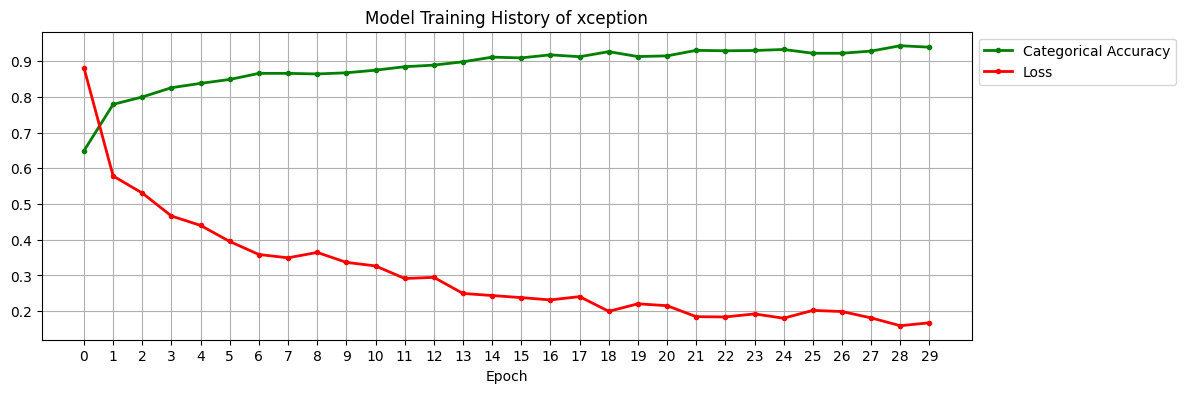

In [34]:
plt.figure(figsize=(12, 4))
plt.grid(True)
plt.plot(train_history_xception.history['categorical_accuracy'], '.g-', linewidth=2, label='Categorical Accuracy')
plt.plot(train_history_xception.history['loss'], '.r-', linewidth=2, label='Loss')
plt.title('Model Training History of xception')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history_xception.history['categorical_accuracy'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

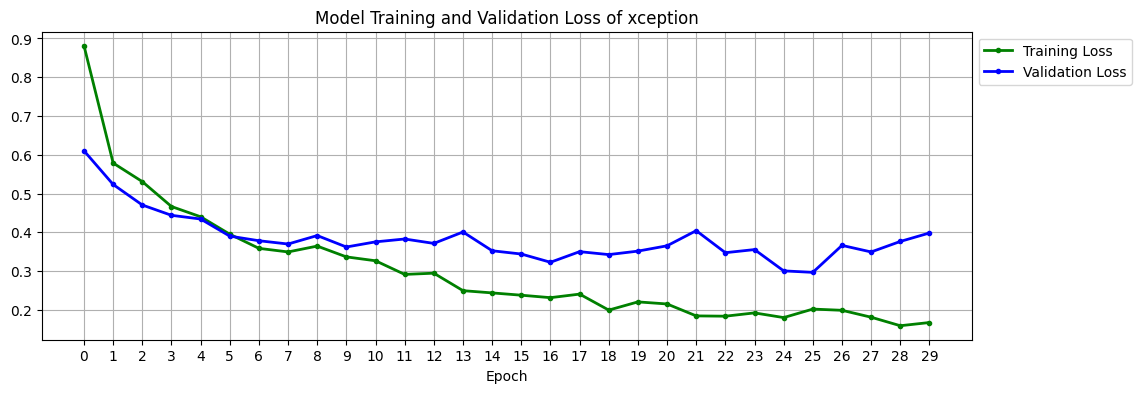

In [35]:
plt.figure(figsize=(12, 4))
plt.grid(True)

# Plot training loss
plt.plot(train_history_xception.history['loss'], '.g-', label='Training Loss', linewidth=2)

# Plot validation loss if available
if 'val_loss' in train_history_xception.history:
    plt.plot(train_history_xception.history['val_loss'], '.b-', label='Validation Loss', linewidth=2)

plt.title('Model Training and Validation Loss of xception')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history_xception.history['loss'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [36]:
# Evaluate the model on the test set
evaluation_results_xception = model_xception.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_xception[0]}')
print(f'Test Accuracy: {evaluation_results_xception[1]}')

7/7 [==============================] - 2s 287ms/step - loss: 1.7646 - categorical_accuracy: 0.7081
Test Loss: 1.7645750045776367
Test Accuracy: 0.7081218361854553


In [37]:
y_perd_xception = model_xception.predict(test_dataset)

7/7 [==============================] - 2s 186ms/step


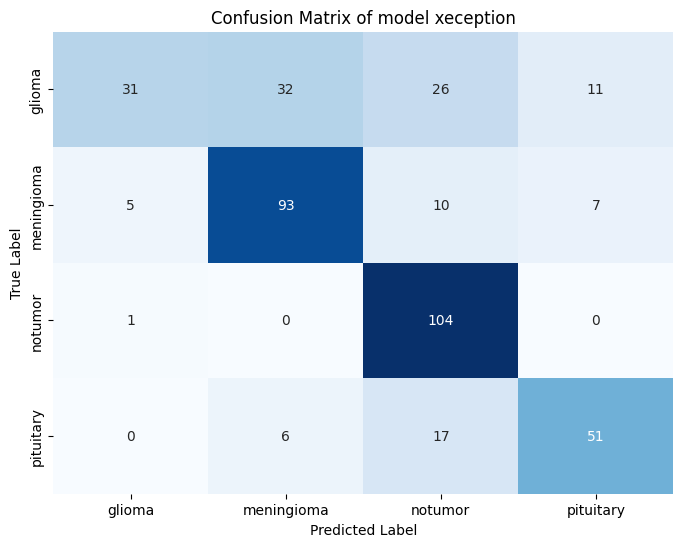

In [38]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_xception,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix of xception
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of model xeception')
plt.show()

In [39]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_xception,axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.31      0.45       100
           1       0.71      0.81      0.76       115
           2       0.66      0.99      0.79       105
           3       0.74      0.69      0.71        74

    accuracy                           0.71       394
   macro avg       0.74      0.70      0.68       394
weighted avg       0.74      0.71      0.68       394



## 8.3 Development of MobileNet

In [40]:
model_MobileNet =  model_def(MobileNet(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_MobileNet.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dropout_4 (Dropout)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               2097280   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 

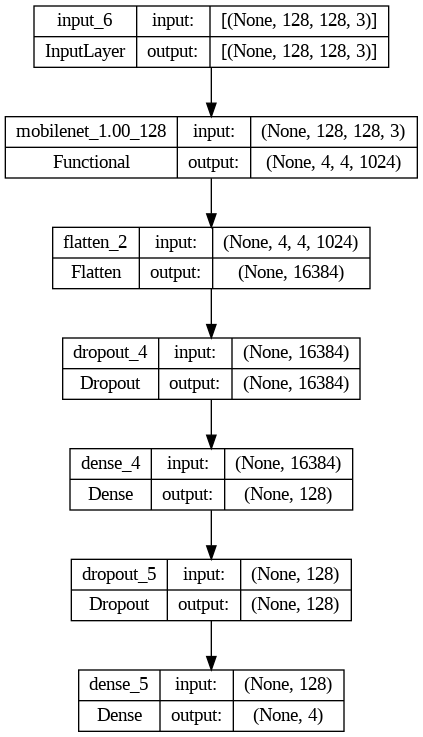

In [41]:
keras.utils.plot_model(model_MobileNet, show_shapes=True)

In [42]:
model_MobileNet.compile(optimizer=Adam(learning_rate=0.0005),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [43]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/MobileNet/epocch_{epoch:02d}.hdf5"

model_MobileNet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [44]:
%%time
train_history_MobileNet = model_MobileNet.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 30,
                          callbacks = [early_stopping, model_MobileNet_checkpoint_callback])

Epoch 1/30
39/39 [==============================] - 26s 550ms/step - loss: 0.8896 - categorical_accuracy: 0.7099 - val_loss: 0.6406 - val_categorical_accuracy: 0.7747
Epoch 2/30
39/39 [==============================] - 20s 524ms/step - loss: 0.4441 - categorical_accuracy: 0.8333 - val_loss: 0.8383 - val_categorical_accuracy: 0.7517
Epoch 3/30
39/39 [==============================] - 21s 546ms/step - loss: 0.3999 - categorical_accuracy: 0.8458 - val_loss: 0.4920 - val_categorical_accuracy: 0.8161
Epoch 4/30
39/39 [==============================] - 21s 545ms/step - loss: 0.3682 - categorical_accuracy: 0.8686 - val_loss: 0.3982 - val_categorical_accuracy: 0.8575
Epoch 5/30
38/39 [============================>.] - ETA: 0s - loss: 0.3172 - categorical_accuracy: 0.8850
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/MobileNet/epocch_05.hdf5
39/39 [==============================] - 22s 568ms/step - loss: 0.3164 - categorical_accuracy: 0.8852 - val_loss: 0.3184 - 

In [45]:
print(train_history_MobileNet.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


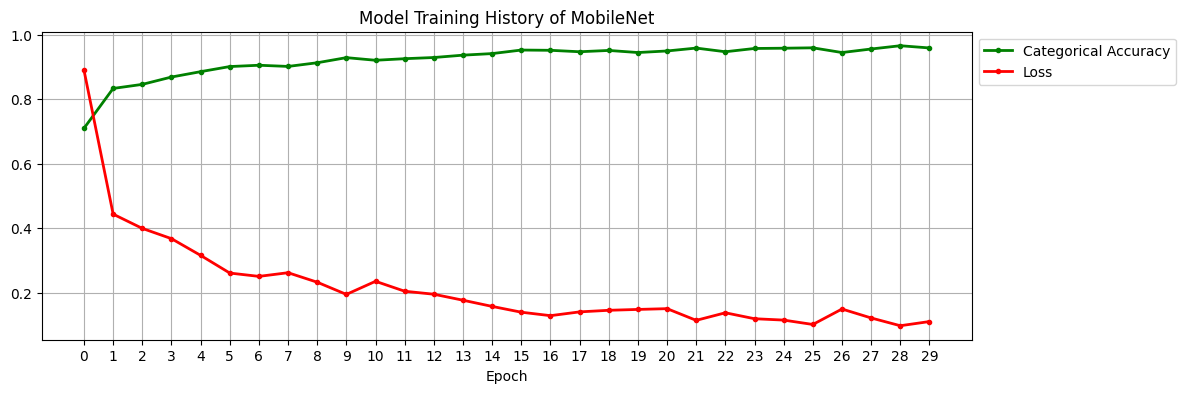

In [46]:
plt.figure(figsize=(12, 4))
plt.grid(True)
plt.plot(train_history_MobileNet.history['categorical_accuracy'], '.g-', linewidth=2, label='Categorical Accuracy')
plt.plot(train_history_MobileNet.history['loss'], '.r-', linewidth=2, label='Loss')
plt.title('Model Training History of MobileNet')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history_MobileNet.history['categorical_accuracy'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

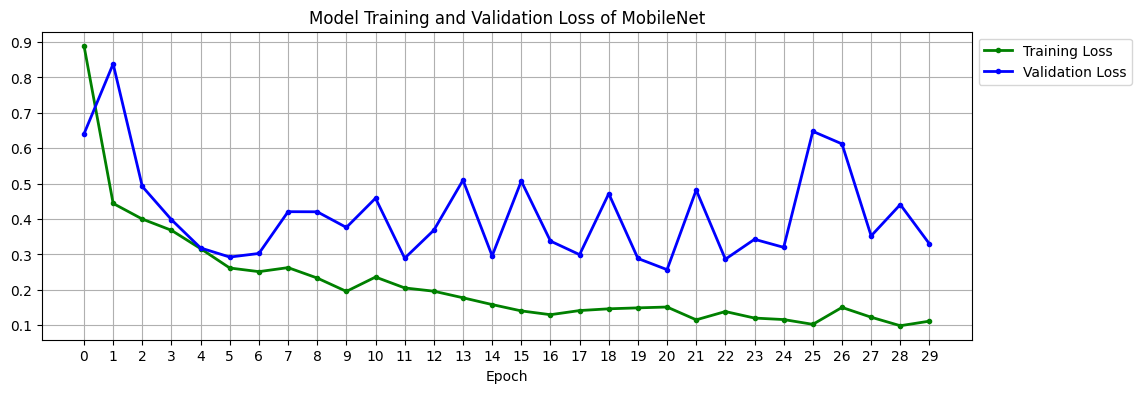

In [47]:
plt.figure(figsize=(12, 4))
plt.grid(True)

# Plot training loss
plt.plot(train_history_MobileNet.history['loss'], '.g-', label='Training Loss', linewidth=2)

# Plot validation loss if available
if 'val_loss' in train_history_MobileNet.history:
    plt.plot(train_history_MobileNet.history['val_loss'], '.b-', label='Validation Loss', linewidth=2)

plt.title('Model Training and Validation Loss of MobileNet')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history_MobileNet.history['loss'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [48]:
# Evaluate the model on the test set
evaluation_results_MobileNet = model_MobileNet.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_MobileNet[0]}')
print(f'Test Accuracy: {evaluation_results_MobileNet[1]}')

7/7 [==============================] - 2s 215ms/step - loss: 3.0769 - categorical_accuracy: 0.7741
Test Loss: 3.0769143104553223
Test Accuracy: 0.7741116881370544


In [49]:
y_perd_MobileNet = model_MobileNet.predict(test_dataset)

7/7 [==============================] - 2s 164ms/step


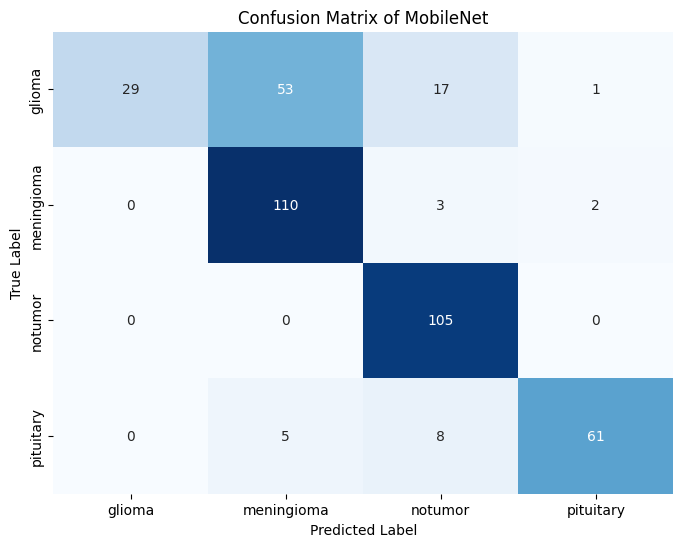

In [50]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix of MobileNet
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_MobileNet,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix of MobileNet
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of MobileNet')
plt.show()

In [51]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_MobileNet,axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.29      0.45       100
           1       0.65      0.96      0.78       115
           2       0.79      1.00      0.88       105
           3       0.95      0.82      0.88        74

    accuracy                           0.77       394
   macro avg       0.85      0.77      0.75       394
weighted avg       0.83      0.77      0.74       394



# 7.4 Development of ReseNet50

In [52]:
model_ResNet50 =  model_def(ResNet50(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_ResNet50.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_6 (Dropout)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                       

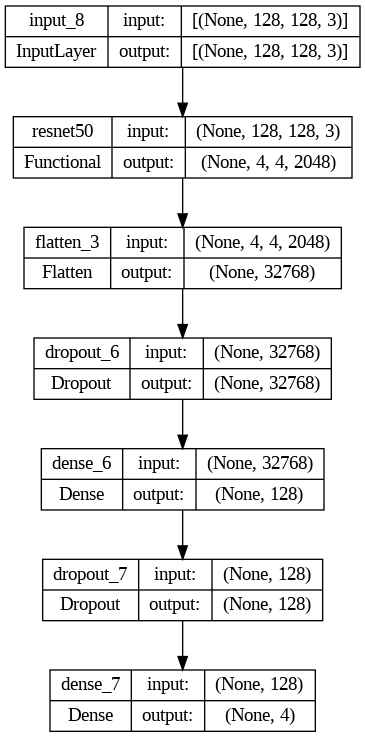

In [53]:
keras.utils.plot_model(model_ResNet50, show_shapes=True)

In [54]:
model_ResNet50.compile(optimizer=Adam(learning_rate=0.0005),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [55]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/ResNet50/epocch_{epoch:02d}.hdf5"

model_ResNet50_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [56]:
%%time
train_history_ResNet50 = model_ResNet50.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 30,
                          callbacks = [early_stopping, model_ResNet50_checkpoint_callback])

Epoch 1/30
39/39 [==============================] - 34s 594ms/step - loss: 1.8011 - categorical_accuracy: 0.3351 - val_loss: 1.3112 - val_categorical_accuracy: 0.3356
Epoch 2/30
39/39 [==============================] - 21s 542ms/step - loss: 1.2038 - categorical_accuracy: 0.4556 - val_loss: 1.3071 - val_categorical_accuracy: 0.2897
Epoch 3/30
39/39 [==============================] - 21s 543ms/step - loss: 1.1692 - categorical_accuracy: 0.4625 - val_loss: 1.2844 - val_categorical_accuracy: 0.3494
Epoch 4/30
39/39 [==============================] - 24s 621ms/step - loss: 1.1316 - categorical_accuracy: 0.4872 - val_loss: 1.2350 - val_categorical_accuracy: 0.4828
Epoch 5/30
38/39 [============================>.] - ETA: 0s - loss: 1.1259 - categorical_accuracy: 0.4856
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/ResNet50/epocch_05.hdf5
39/39 [==============================] - 23s 602ms/step - loss: 1.1269 - categorical_accuracy: 0.4856 - val_loss: 1.1556 - v

In [57]:
print(train_history_ResNet50.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


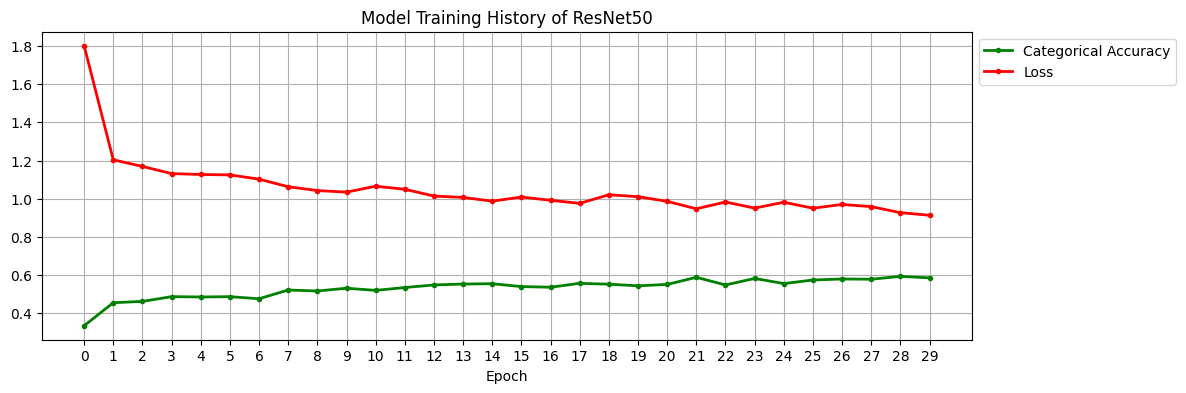

In [58]:
plt.figure(figsize=(12, 4))
plt.grid(True)
plt.plot(train_history_ResNet50.history['categorical_accuracy'], '.g-', linewidth=2, label='Categorical Accuracy')
plt.plot(train_history_ResNet50.history['loss'], '.r-', linewidth=2, label='Loss')
plt.title('Model Training History of ResNet50')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history_ResNet50.history['categorical_accuracy'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

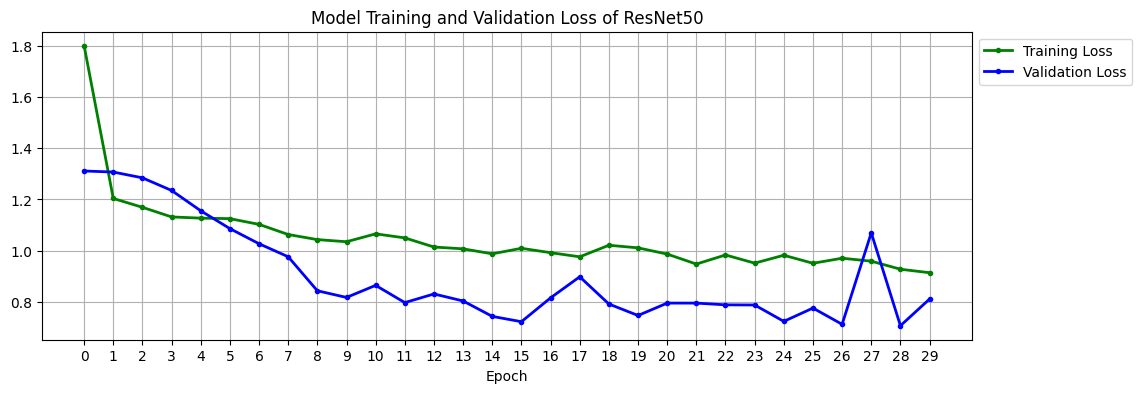

In [59]:
plt.figure(figsize=(12, 4))
plt.grid(True)

# Plot training loss
plt.plot(train_history_ResNet50.history['loss'], '.g-', label='Training Loss', linewidth=2)

# Plot validation loss if available
if 'val_loss' in train_history_ResNet50.history:
    plt.plot(train_history_ResNet50.history['val_loss'], '.b-', label='Validation Loss', linewidth=2)

plt.title('Model Training and Validation Loss of ResNet50')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history_ResNet50.history['loss'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [60]:
# Evaluate the model on the test set
evaluation_results_ResNet50 = model_ResNet50.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_ResNet50[0]}')
print(f'Test Accuracy: {evaluation_results_ResNet50[1]}')

7/7 [==============================] - 2s 247ms/step - loss: 1.9702 - categorical_accuracy: 0.4112
Test Loss: 1.9702138900756836
Test Accuracy: 0.4111675024032593


In [61]:
y_perd_ResNet50 = model_ResNet50.predict(test_dataset)

7/7 [==============================] - 3s 231ms/step


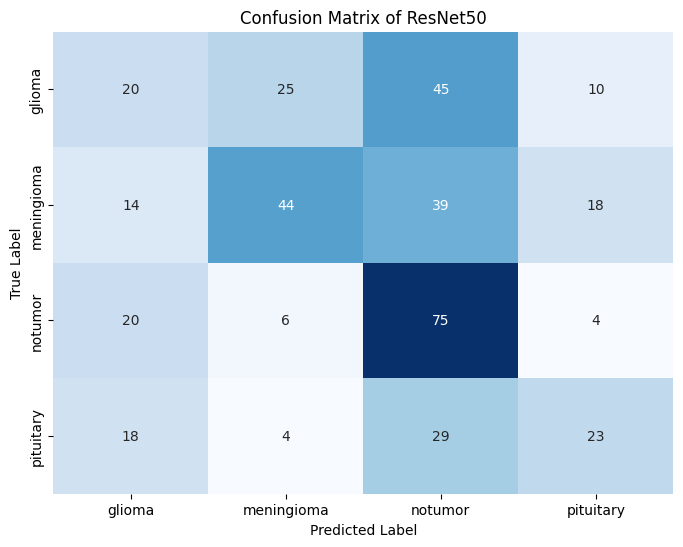

In [62]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix of ResNet50
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_ResNet50,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of ResNet50')
plt.show()

In [63]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_ResNet50,axis=1)))

              precision    recall  f1-score   support

           0       0.28      0.20      0.23       100
           1       0.56      0.38      0.45       115
           2       0.40      0.71      0.51       105
           3       0.42      0.31      0.36        74

    accuracy                           0.41       394
   macro avg       0.41      0.40      0.39       394
weighted avg       0.42      0.41      0.39       394



## Model Analysis and Comparison

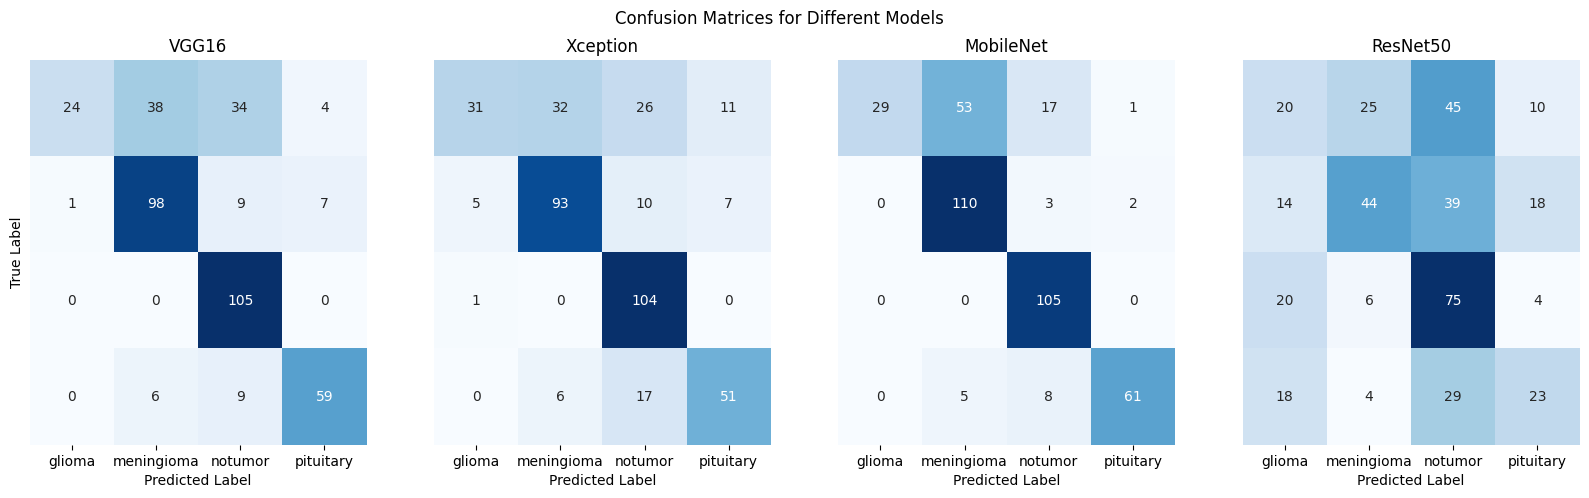

In [64]:
unique_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix for VGG16
conf_matrix_vgg = confusion_matrix(test_dataset.labels, np.argmax(y_perd_vgg, axis=-1))
conf_matrix_data_vgg = np.array(conf_matrix_vgg)

# Confusion matrix for Xception
conf_matrix_xception = confusion_matrix(test_dataset.labels, np.argmax(y_perd_xception, axis=-1))
conf_matrix_data_xception = np.array(conf_matrix_xception)

# Confusion matrix for MobileNet
conf_matrix_mobileNet = confusion_matrix(test_dataset.labels, np.argmax(y_perd_MobileNet, axis=-1))
conf_matrix_data_mobileNet = np.array(conf_matrix_mobileNet)

# Confusion matrix for ResNet50
conf_matrix_resNet50 = confusion_matrix(test_dataset.labels, np.argmax(y_perd_ResNet50, axis=-1))
conf_matrix_data_resNet50 = np.array(conf_matrix_resNet50)

# Plotting the confusion matrices side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# VGG16
sns.heatmap(conf_matrix_data_vgg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('VGG16')

# Xception
sns.heatmap(conf_matrix_data_xception, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels, yticklabels=[], ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_title('Xception')

# MobileNet
sns.heatmap(conf_matrix_data_mobileNet, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels, yticklabels=[], ax=axes[2])
axes[2].set_xlabel('Predicted Label')
axes[2].set_title('MobileNet')

# ResNet50
sns.heatmap(conf_matrix_data_resNet50, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels, yticklabels=[], ax=axes[3])
axes[3].set_xlabel('Predicted Label')
axes[3].set_title('ResNet50')

plt.suptitle('Confusion Matrices for Different Models')
plt.show()


- The diagonal elements represent correctly predicted instances (True Positives).


- Off-diagonal elements represent misclassifications (False Positives and False Negatives).


- The higher the diagonal values of the confusion matrix, the better the model's performance.


- The values on the diagonal of the confusion matrix represent the number of correctly classified instances for each class.

**Observation:**


- For Glioma (Class 0): The model correctly identified 391 instances of Glioma (TP), but there were X instances misclassified as other classes ('meningioma', 'notumor', or 'pituitary').


- For Meningioma (Class 1): The model correctly identified 1355 instances of Meningioma (TP), and there was X misclassification.



- No Tumor (Class 2):The model correctly identified 1305 instances of No Tumor (TP), and there was  X misclassification.



- Pituitary (Class 3) : The model correctly identified 767 instances of Pituitary (TP), but there were 19 instances misclassified as other classes.



- In conclusion, The model has a noticeable number of misclassifications, especially in the 'glioma' class (Class 0) and the 'pituitary' class (Class 3).



- Further analysis, such as examining precision, recall, and F1-score for each class, could provide a more comprehensive evaluation of the model's strengths and weaknesses. Additionally, fine-tuning the model, adjusting hyperparameters, or using more advanced architectures may help improve performance.
